In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import argparse
import logging
import shutil
import re
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from torchvision.datasets import VisionDataset
from torchvision import transforms
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from utils import *
%matplotlib inline

DATA_DIR = '/data/amiratag/prostate'
MEM_DIR = '/home/amiratag/Projects/Prostate'

In [2]:
model_dir = os.path.join(MEM_DIR, 'models/random_flips')

In [3]:
cudnn.benchmark = True
# useful setting for debugging
# cudnn.benchmark = False
# cudnn.deterministic = True
use_cuda = torch.cuda.is_available()
device = torch.device('cuda') if use_cuda else 'cpu'

Load tile model

In [4]:
num_classes = 6
im_shape = (224, 224)
model = DenseNet(num_classes)
if use_cuda:
    model = torch.nn.DataParallel(model).cuda()
checkpoints = [i for i in os.listdir(model_dir) if '.pt' in i]
checkpoints_epoch_num = [int(re.search('epoch(\d+)', c).group(1)) for c in checkpoints]
last_epoch = np.max(checkpoints_epoch_num)
checkpoint = torch.load(os.path.join(model_dir, 'checkpoint-epoch{}.pt'.format(last_epoch)))
state_dict = checkpoint.get('state_dict', checkpoint)
model.load_state_dict(state_dict)
model.eval()

DataParallel(
  (module): DenseNet(
    (feature_extractor): DenseNet(
      (features): Sequential(
        (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU(inplace=True)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): _DenseBlock(
          (denselayer1): _DenseLayer(
            (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace=True)
            (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (denselayer2): _D

Read test slides

In [5]:
train_csv = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
gleason_scores = train_csv['gleason_score'][train_csv['data_provider'] == 'radboud'].values[-1000:]
valid_images = train_csv['image_id'][train_csv['data_provider'] == 'radboud'].values[-1000:]
image_paths = [os.path.join(DATA_DIR, 'train_images', i)+'.tiff' for i in valid_images
               if os.path.exists(os.path.join(DATA_DIR, 'train_images', i)+'.tiff')]
mask_paths = [i.replace('train_images','train_label_masks').replace('.tiff', '_mask.tiff') for i in image_paths]
gleason_scores_dic = {image_paths[i].split('/')[-1].split('.')[0]: gleason_scores[i]
                      for i in range(len(gleason_scores))}

Run tile model and test slides (tile by tile)

In [ ]:
for i in tqdm(range(1000)):
    image_path, mask_path = image_paths[i], mask_paths[i]
    image_name = image_path.split('/')[-1].split('.')[0]
    try:
        slide = io.imread(image_path)
        mask = io.imread(mask_path)
    except:
        continue
    gleason_scores[i]
    size = slide.shape
    predicted_mask = np.zeros((size[0] // im_shape[0], size[1] // im_shape[1]))
    counter = 0
    indices = []
    batch = []
    for w in range(size[0] // im_shape[0]):
        for h in range(size[1] // im_shape[1]):
            img = slide[w * im_shape[0]: (w+1) * im_shape[0], h * im_shape[1]: (h+1) * im_shape[1]]
            X = transforms.ToTensor()(Image.fromarray(img))
            if use_cuda:
                X = X.to(device)
            pred = np.argmax(model(torch.stack([X])).detach().cpu().numpy()[0])
            predicted_mask[w, h] = pred
    np.save(os.path.join('predicted_masks', image_name+'.npy'), predicted_mask)

  0%|          | 1/1000 [01:29<24:45:48, 89.24s/it]

Predict slide level scores (not correct)

In [16]:
probs, primary, predicted = [], [], []
for i in range(len(image_paths)):
    image_path, mask_path = image_paths[i], mask_paths[i]
    image_name = image_path.split('/')[-1].split('.')[0]
    if not os.path.exists(os.path.join('predicted_masks', image_name+'.npy')):
        continue
    predicted_mask = np.load(os.path.join('predicted_masks', image_name+'.npy'))
    probs.append(np.array([np.mean(predicted_mask == j) for j in range(6)]))
    present = np.where(probs[-1] > 0.01)[0]
    if len(present) >= 2:
        predicted_prim = present[-1]
        predicted_second = present[-2]
        if predicted_prim == 5 and predicted_second <3:
            predicted_second = 5
        if predicted_prim == 4 and predicted_second <3:
            predicted_second = 4
        if predicted_prim == 3 and predicted_second != 3:
            predicted_second = 3
    else:
        predicted_second = predicted_prim
    predicted_score = '{}+{}'.format(predicted_prim, predicted_second) if predicted_second >=3 else 'negative'
    predicted.append(predicted_score)
    primary.append(gleason_scores_dic[image_name])
    print(['{0:.3f}'.format(np.mean(predicted_mask == j)) for j in range(6)], gleason_scores[i], predicted_score)
primary, probs, predicted = np.array(primary), np.array(probs), np.array(predicted)

['0.779', '0.140', '0.027', '0.003', '0.048', '0.003'] 4+4 4+4
['0.698', '0.215', '0.081', '0.000', '0.004', '0.002'] negative negative
['0.810', '0.105', '0.005', '0.000', '0.072', '0.008'] 4+4 4+4
['0.717', '0.209', '0.073', '0.000', '0.000', '0.000'] negative negative
['0.816', '0.105', '0.023', '0.038', '0.014', '0.005'] 4+4 4+3
['0.722', '0.127', '0.006', '0.090', '0.040', '0.016'] 3+3 5+4
['0.856', '0.052', '0.036', '0.039', '0.017', '0.001'] 3+4 4+3
['0.526', '0.186', '0.013', '0.241', '0.029', '0.004'] 3+4 4+3
['0.834', '0.096', '0.065', '0.001', '0.000', '0.003'] negative negative
['0.748', '0.183', '0.068', '0.000', '0.000', '0.000'] negative negative
['0.712', '0.107', '0.004', '0.000', '0.153', '0.024'] 4+4 5+4
['0.931', '0.029', '0.002', '0.006', '0.025', '0.009'] 3+4 4+4
['0.729', '0.206', '0.011', '0.052', '0.000', '0.001'] 3+3 3+3
['0.815', '0.069', '0.008', '0.000', '0.078', '0.030'] 5+4 5+4
['0.848', '0.043', '0.006', '0.046', '0.052', '0.005'] 4+3 4+3
['0.684', '0.08

['0.559', '0.155', '0.005', '0.000', '0.197', '0.083'] 4+4 5+4
['0.636', '0.335', '0.029', '0.000', '0.000', '0.000'] negative negative
['0.794', '0.071', '0.044', '0.067', '0.020', '0.003'] 4+3 4+3
['0.820', '0.120', '0.022', '0.003', '0.015', '0.019'] 4+5 5+4
['0.740', '0.200', '0.060', '0.001', '0.000', '0.000'] negative negative
['0.842', '0.101', '0.017', '0.000', '0.006', '0.034'] 5+5 5+5
['0.745', '0.167', '0.005', '0.002', '0.017', '0.065'] 4+5 5+4
['0.848', '0.058', '0.017', '0.042', '0.029', '0.006'] 4+3 4+3
['0.832', '0.085', '0.053', '0.028', '0.001', '0.002'] 3+3 3+3
['0.826', '0.150', '0.018', '0.001', '0.003', '0.002'] negative negative
['0.866', '0.062', '0.013', '0.051', '0.007', '0.000'] 3+4 3+3
['0.806', '0.108', '0.026', '0.000', '0.025', '0.035'] 4+5 5+4
['0.866', '0.080', '0.015', '0.001', '0.008', '0.032'] 4+5 5+5
['0.783', '0.075', '0.008', '0.001', '0.060', '0.073'] 4+5 5+4
['0.530', '0.155', '0.004', '0.007', '0.251', '0.052'] 3+4 5+4
['0.803', '0.169', '0.021

['0.706', '0.118', '0.071', '0.099', '0.002', '0.003'] 3+3 3+3
['0.601', '0.161', '0.019', '0.092', '0.120', '0.007'] 4+3 4+3
['0.673', '0.131', '0.196', '0.000', '0.000', '0.000'] negative negative
['0.526', '0.308', '0.081', '0.073', '0.009', '0.002'] 3+3 3+3
['0.544', '0.158', '0.079', '0.195', '0.019', '0.004'] 3+3 4+3
['0.910', '0.050', '0.015', '0.000', '0.010', '0.015'] 5+4 5+5
['0.825', '0.091', '0.025', '0.018', '0.016', '0.025'] 5+5 5+4
['0.700', '0.245', '0.053', '0.001', '0.001', '0.000'] negative negative
['0.736', '0.128', '0.015', '0.001', '0.021', '0.100'] 5+4 5+4
['0.742', '0.056', '0.024', '0.143', '0.035', '0.000'] 3+4 4+3
['0.547', '0.156', '0.017', '0.013', '0.080', '0.188'] 4+5 5+4
['0.732', '0.177', '0.039', '0.005', '0.034', '0.013'] 4+3 5+4
['0.771', '0.093', '0.036', '0.050', '0.049', '0.002'] 4+4 4+3
['0.790', '0.110', '0.099', '0.001', '0.000', '0.000'] negative negative
['0.536', '0.423', '0.042', '0.000', '0.000', '0.000'] 4+4 negative
['0.840', '0.084', '

['0.713', '0.118', '0.002', '0.000', '0.003', '0.165'] 5+4 5+5
['0.622', '0.164', '0.008', '0.147', '0.057', '0.001'] 3+4 4+3
['0.829', '0.101', '0.054', '0.008', '0.003', '0.004'] 3+3 negative
['0.713', '0.182', '0.080', '0.009', '0.014', '0.002'] 4+5 4+4
['0.792', '0.124', '0.084', '0.000', '0.000', '0.000'] negative negative
['0.760', '0.138', '0.102', '0.001', '0.000', '0.000'] negative negative
['0.794', '0.079', '0.037', '0.085', '0.004', '0.001'] 3+5 3+3
['0.592', '0.295', '0.021', '0.000', '0.045', '0.048'] 5+5 5+4
['0.706', '0.155', '0.046', '0.000', '0.056', '0.037'] 4+4 5+4
['0.639', '0.196', '0.036', '0.110', '0.019', '0.001'] 3+3 4+3
['0.723', '0.109', '0.023', '0.007', '0.114', '0.025'] 4+3 5+4
['0.861', '0.040', '0.004', '0.026', '0.066', '0.002'] 4+4 4+3
['0.788', '0.085', '0.017', '0.092', '0.017', '0.002'] 3+4 4+3
['0.742', '0.211', '0.012', '0.000', '0.021', '0.014'] 4+4 5+4
['0.775', '0.136', '0.088', '0.000', '0.001', '0.000'] negative negative
['0.766', '0.161', '

(-0.5, 2251.5, 1381.5, -0.5)

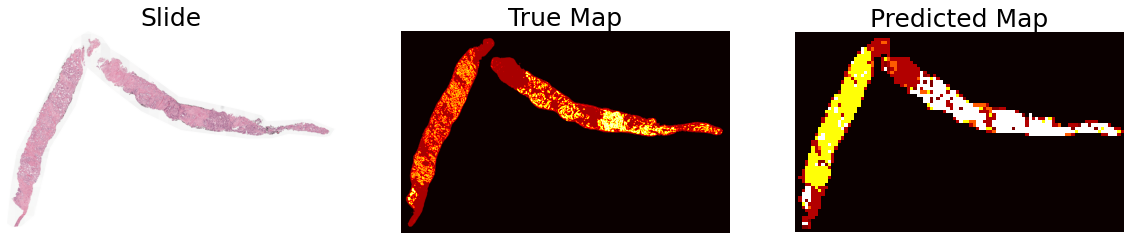

In [10]:
fig = plt.figure(figsize=(20, 20))
image_name = image_paths[i].split('/')[-1].split('.')[0]
msk = io.imread(mask_paths[i])
img = io.imread(image_paths[i])
size = msk.shape
plt.subplot(1, 3, 3)
plt.title('Predicted Map', fontsize=25)
predicted_mask = np.load(os.path.join('predicted_masks', image_name+'.npy'))
plt.imshow((predicted_mask * 60).astype(np.uint8), cmap='hot')
plt.axis('off')
plt.subplot(1, 3, 1)
plt.title('Slide', fontsize=25)
plt.imshow(np.array(Image.fromarray(img).resize((size[1]//10, size[0]//10))))
plt.axis('off')
plt.subplot(1, 3, 2)
msk = io.imread(mask_paths[i])
size = msk.shape
plt.title('True Map', fontsize=25)
plt.imshow(np.array(Image.fromarray(msk * 60).resize((size[1]//10, size[0]//10)))[..., 0], cmap='hot')
plt.axis('off')